# Comparison of the methods for EOT with fixed $\varepsilon$
___
In this notebook, we are going to compare Sinkhorn algorithm, SGD, and LBFGS for solving dual EOT problem:
$$
    \sup_{\substack{\textbf{u} \in \mathbb{R}^{N_1} \\ \textbf{v} \in \mathbb{R}^{N_2}}} \sum_{i = 1}^{N_1} u_i a_i + \sum_{j = 1}^{N_2} v_j b_j
                - \varepsilon \sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} \exp(\frac{u_i + v_j - C_{ij}}{\varepsilon}),
$$
where $\textbf{C} \in \mathbb{R}^{N_1 \times N_2}_+$ is a *cost matrix*, $\textbf{a} \in \mathbb{R}^{N_1}_+, \textbf{b} \in \mathbb{R}^{N_2}_+$ are the marginals normalized to $1$, and $\varepsilon > 0$ is a *regularization parameter*.

The main interest is next. Given $\varepsilon > 0$, find out which algorithm will reach $\alpha(\varepsilon)$-precision faster (mainly, in terms of time), i.e.
$$
    \langle \textbf{C}, \textbf{P}^{exact} \rangle < \langle \textbf{C}, \textbf{P}^{approx} \rangle \leq \langle \textbf{C}, \textbf{P}^{exact} \rangle + \alpha(\varepsilon),
$$
where $\alpha(\varepsilon) > 0$ is some function (typically, $\alpha(\varepsilon) = \varepsilon$).

Here, we compute $\textbf{P}^{approx}$ from obtained potentials $u, v$ using formula
$$
    \textbf{P}^{approx}_{ij} = u_i K_{ij} v_j \quad \forall i \in [N_1],\ j \in [N_2],
$$
where $K_{ij} = e^{-\frac{C_{ij}}{\varepsilon}}$, and then, in order to have correct marginals, update $\textbf{P}^{approx}$ using procedure, described in [1], remark 4.6.

As marginals, the $\text{Beta}(\alpha, \beta)$ distribution will be used with different parameters.

In [1]:
import numpy as np
from scipy import stats
import ot.plot
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import optax
import jaxopt
from tqdm import trange
import time
jax.config.update("jax_enable_x64", True)

In [2]:
def get_summary(alg_step, init_uv, init_state, primal_val, delta, max_iters):
    uv = init_uv
    state = init_state
    iter_times = []
    reached_iter_limit = True
    nan_encountered = False
    for i in trange(max_iters):
        start_time = time.time()
        new_uv, val, state = alg_step(uv, state)
        end_time = time.time()
        
        exp_tr0 = jnp.exp(uv[0] / eps)
        exp_tr1 = jnp.exp(uv[1] / eps)
        if jnp.any(jnp.isnan(new_uv[0])) or jnp.any(jnp.isnan(new_uv[1])) or jnp.all(exp_tr0 == 0) or jnp.all(exp_tr1 == 0):
            nan_encountered = True
            break
        
        iter_time = end_time - start_time
        iter_times.append(iter_time)
        # if jnp.linalg.norm(uv[0] - new_uv[0]) < delta and jnp.linalg.norm(uv[1] - new_uv[1]) < delta:
        #     reached_iter_limit = False
        #     break
        uv = new_uv
        P = get_coupling(*uv)
        if primal_val < jnp.trace(P.T @ C) <= primal_val + delta:
            reached_iter_limit = False
            break

            
    if nan_encountered:
        print(f"""
        NaN encountered or too small entries in the potentials. Termination.
        (Hint: try bigger epsilon) \n
        Total execution time: {round(sum(iter_times), 4)}s
        Avg. iteration time: {round(np.mean(iter_times), 8)}s
        Number of iterations to reach given precision: ?
        """)
    elif reached_iter_limit:
        print(f"""
        Reached iteration limit. Precision was not attained. \n
        Total execution time: {round(sum(iter_times), 4)}s
        Avg. iteration time: {round(np.mean(iter_times), 8)}s
        Number of iterations to reach given precision: >{max_iters}
        """)
    else:
        print(f"""
        Termination successful. Precision is attained. \n
        Total execution time: {round(sum(iter_times), 4)}s
        Avg. iteration time: {round(np.mean(iter_times), 8)}s
        Number of iterations to reach given precision: {len(iter_times)}
        """)


def get_reg_dual_problem_value(u, v, a, b, K, eps):
    u_exp = jnp.exp(u / eps)
    v_exp = jnp.exp(v / eps)
    return a @ u + b @ v - eps * (u_exp @ (K @ v_exp))

def get_coupling(u, v):
    u_exp = jnp.exp(u / eps)
    v_exp = jnp.exp(v / eps)
    P = jnp.einsum('i,ij,j->ij', u_exp, K, v_exp)
    
    up = u_exp * jnp.minimum(a / (u_exp * (K @ v_exp)), 1.)
    vp = v_exp * jnp.minimum(b / (v_exp * (K.T @ up)), 1.)
    delta_a = a - up * (K @ vp)
    delta_b = b - vp * (K.T @ u_exp)
    P = P + np.einsum('i,j->ij', delta_a, delta_b) / jnp.linalg.norm(delta_a, ord=1)
    
    return P


def init_sgd(lrate):
    opt = optax.yogi(learning_rate=lrate)
    state = opt.init(init_uv)
    
    return opt, state 


def init_lbfgs(F):
    opt = jaxopt.LBFGS(fun=F, has_aux=False, jit=True)
    state = opt.init_state(init_uv)
    
    return opt, state

## Initialize data

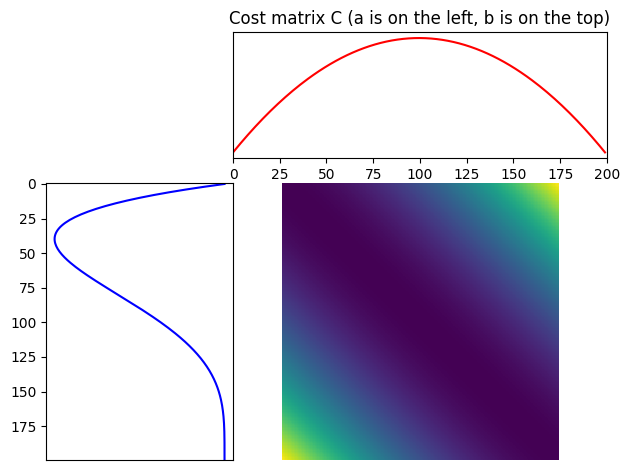

In [3]:
# X arrays for the marginals
n1 = 200  # Number of points in first marginal discretisation
x1 = np.linspace(0, 1, n1)
n2 = n1  # Number of points in second marginal discretisation
x2 = np.linspace(0, 1, n2)

# Initialize first marginal with beta distribution
a1, b1 = 2, 5  # Distribution parameters
a = stats.beta(a1, b1).pdf(x1)  # Sample from the distribution
a = np.maximum(a, 1e-30)  # Substitute 0 with 1e-30 to omit -inf in log-array
a = a / a.sum()  # Normalize
a = jnp.array(a, dtype=jnp.float64)  # Convert to jax ndarray
a_log = jnp.log(a)  # Compute log-array

# Initialize second marginal with beta distribution
a2, b2 = 2, 2  # Distribution parameters
b = stats.beta(a2, b2).pdf(x2)  # Sample from the distribution
b = np.maximum(b, 1e-30)  # Substitute 0 with 1e-30 to omit -inf in log-array
b = b / b.sum()  # Normalize
b = jnp.array(b, dtype=jnp.float64)  # Convert to jax ndarray
b_log = jnp.log(b)  # Compute log-array

# Initialize cost matrix
C = ot.dist(x1.reshape((n1, 1)), x2.reshape((n2, 1)))  # Compute cost matrix
C = C / C.max()  # Normalize cost matrix
C = jnp.array(C, dtype=jnp.float64)  # Convert to jax ndarray

# Initialize potentials
u = jnp.zeros(n1, dtype=jnp.float64)
v = jnp.zeros(n2, dtype=jnp.float64)
init_uv = (u, v)

eps = 1e-3  # Regularization parameter
K = jnp.array(np.exp(-C / eps), dtype=jnp.float64)  # Gibbs kernel of the cost matrix

# Objective function for 1st and 2nd order methods
F = lambda uv: -get_reg_dual_problem_value(uv[0], uv[1], a, b, K, eps)
get_grad = jax.grad(F)

alpha = eps  # Target precision
max_iters = 20000  # Max iteration allowed in the summary function

ot.plot.plot1D_mat(a, b, C, 'Cost matrix C (a is on the left, b is on the top)')

## Exact solution of the primal problem

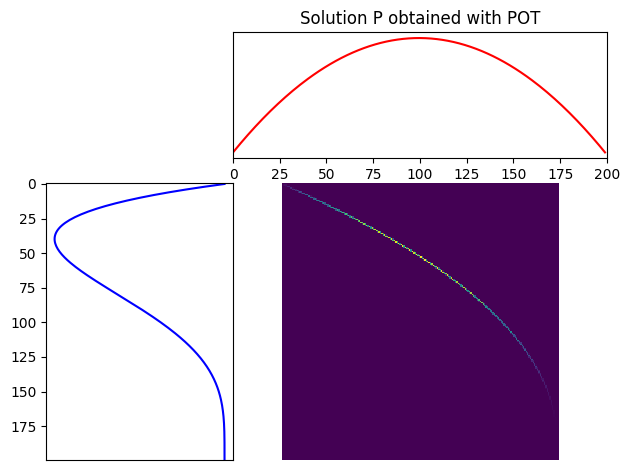

In [4]:
P_exact = ot.lp.emd(np.asarray(a), np.asarray(b), np.asarray(C))
P_exact = jnp.array(P_exact)
primal_val = jnp.trace(P_exact.T @ C)
ot.plot.plot1D_mat(a, b, P_exact, 'Solution P obtained with POT')

## Tests

### Sinkhorn algorithm

In [5]:
@jax.jit
def sink_step(uv, state = None):
    u, v = uv
    v_exp = jnp.exp(v / eps)
    u = a_log - jnp.log(K @ v_exp)
    u = u * eps
    
    u_exp = jnp.exp(u / eps)
    v = b_log - jnp.log(K.T @ u_exp)
    v = v * eps
    
    val = get_reg_dual_problem_value(uv[0], uv[1], a, b, K, eps)
    
    return (u, v), val, None

get_summary(sink_step, init_uv, None, primal_val, alpha, max_iters)

  2%|▏         | 398/20000 [00:00<00:31, 630.18it/s]


        Termination successful. Precision is attained. 

        Total execution time: 0.0666s
        Avg. iteration time: 0.00016696s
        Number of iterations to reach given precision: 399
        


### SGD

In [6]:
# Initialize SGD optimizer
sgd_lrate = 1e-2
sgd_opt, sgd_init_state = init_sgd(sgd_lrate)

@jax.jit
def sgd_step(uv, state):
    grad = get_grad(uv)
    updates, state = sgd_opt.update(grad, state, uv)
    uv = optax.apply_updates(uv, updates)
    val = get_reg_dual_problem_value(uv[0], uv[1], a, b, K, eps)
    
    return uv, val, state

get_summary(sgd_step, init_uv, sgd_init_state, primal_val, alpha, max_iters)

 12%|█▏        | 2409/20000 [00:02<00:18, 962.61it/s] 


        Termination successful. Precision is attained. 

        Total execution time: 0.2279s
        Avg. iteration time: 9.458e-05s
        Number of iterations to reach given precision: 2410
        


### LBFGS

In [7]:
# Initialize LBFGS optimizer
lbfgs_opt, lbfgs_init_state = init_lbfgs(F)

@jax.jit
def lbfgs_step(uv, state):
    uv, state = lbfgs_opt.update(uv, state)
    val = get_reg_dual_problem_value(uv[0], uv[1], a, b, K, eps)

    return uv, val, state

get_summary(lbfgs_step, init_uv, lbfgs_init_state, primal_val, alpha, max_iters)

  3%|▎         | 662/20000 [00:01<00:47, 406.15it/s]


        Termination successful. Precision is attained. 

        Total execution time: 0.9805s
        Avg. iteration time: 0.00147894s
        Number of iterations to reach given precision: 663
        


100%|██████████| 600/600 [00:00<00:00, 1038.41it/s]


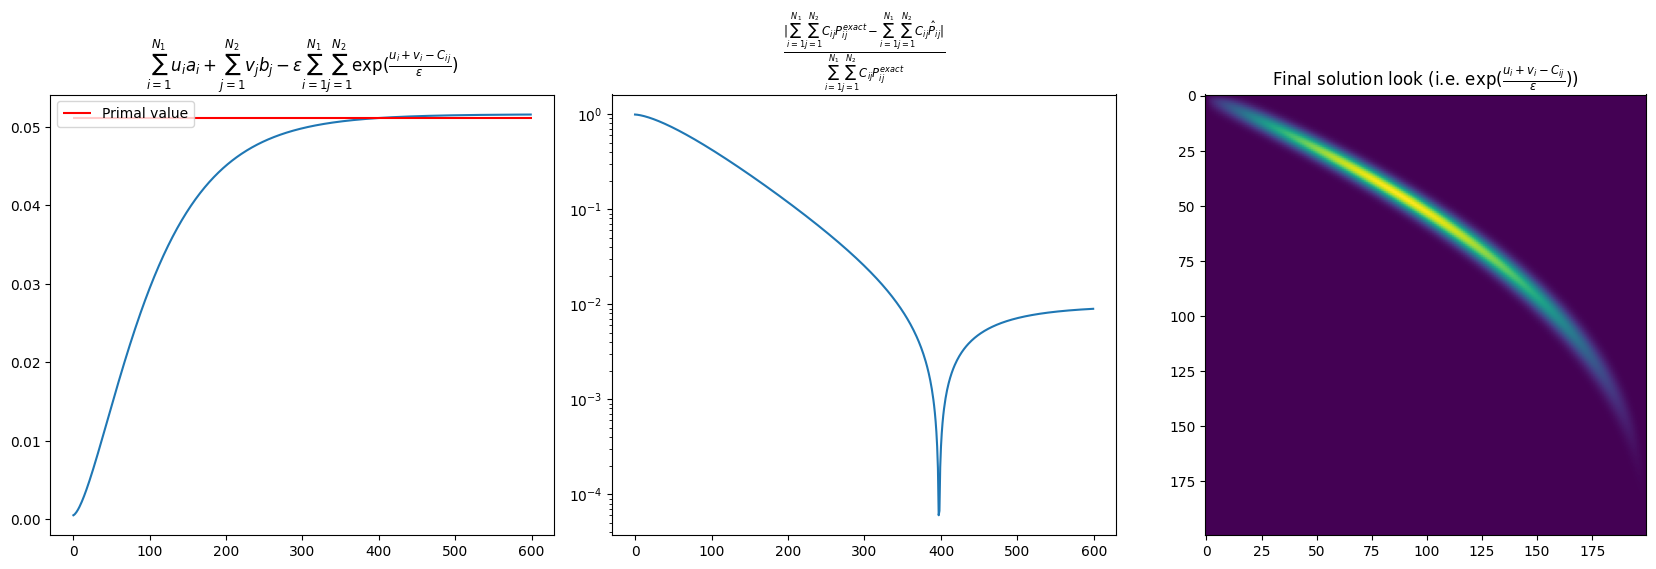

In [8]:
uv = init_uv
n_iters = 600

vals = []
state, step = None, sink_step 
# state, step = sgd_init_state, sgd_step 
# state, step = lbfgs_init_state, lbfgs_step 
for i in trange(n_iters):
    new_uv, val, state = step(uv, state)
    
    idx = np.random.randint(0, 2)
    exp_tr = jnp.exp(uv[idx] / eps)
    if jnp.any(jnp.isnan(new_uv[0])) or jnp.any(jnp.isnan(new_uv[1])) or jnp.all(exp_tr == 0):
        break
    else:
        uv = new_uv
        P = get_coupling(*uv)
        val = jnp.trace(P.T @ C)
        vals.append(val)
        
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
fig.tight_layout()
axs[0].plot(vals)
axs[0].hlines(primal_val, 0, len(vals), colors='red', label='Primal value')
axs[0].legend()
axs[0].set_title(r'$\sum_{i = 1}^{N_1} u_i a_i + \sum_{j = 1}^{N_2} v_j b_j - \varepsilon \sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} \exp (\frac{u_i + v_i - C_{ij}}{\varepsilon})$')
axs[1].semilogy([abs((primal_val - val) / primal_val) for val in vals])
axs[1].set_title(r'$\frac{|\sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} C_{ij} P^{exact}_{ij} - \sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} C_{ij} \hat{P}_{ij} |}{\sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} C_{ij} P^{exact}_{ij}}$')
axs[2].imshow(P)
axs[2].set_title(r'Final solution look (i.e. $\exp (\frac{u_i + v_i - C_{ij}}{\varepsilon})$)')

plt.show()

100%|██████████| 5000/5000 [00:05<00:00, 958.65it/s]


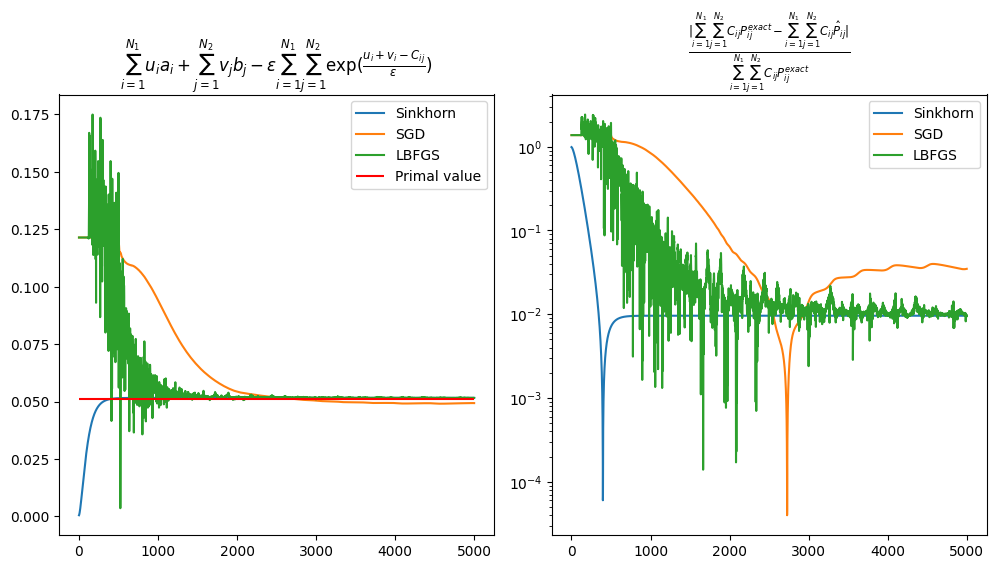

In [9]:
n_iters = 5000

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()

# Sinkhorn

vals = []
state = None
uv = init_uv
for i in trange(n_iters):
    new_uv, val, state = sink_step(uv, state)  # Put here any preferable step (remember to initialize proper state)
    
    idx = np.random.randint(0, 2)
    exp_tr = jnp.exp(uv[idx] / eps)
    if jnp.any(jnp.isnan(new_uv[0])) or jnp.any(jnp.isnan(new_uv[1])) or jnp.all(exp_tr == 0):
        break
    else:
        uv = new_uv
        P = get_coupling(*uv)
        val = jnp.trace(P.T @ C)
        vals.append(val)
axs[0].plot(vals, label='Sinkhorn')
axs[1].semilogy([abs((primal_val - val) / primal_val) for val in vals], label='Sinkhorn')

# SGD

vals = []
state = sgd_init_state
uv = init_uv
for i in trange(n_iters):
    new_uv, val, state = sgd_step(uv, state)  # Put here any preferable step (remember to initialize proper state)
    
    idx = np.random.randint(0, 2)
    exp_tr = jnp.exp(uv[idx] / eps)
    if jnp.any(jnp.isnan(new_uv[0])) or jnp.any(jnp.isnan(new_uv[1])) or jnp.all(exp_tr == 0):
        break
    else:
        uv = new_uv
        P = get_coupling(*uv)
        val = jnp.trace(P.T @ C)
        vals.append(val)
axs[0].plot(vals, label='SGD')
axs[1].semilogy([abs((primal_val - val) / primal_val) for val in vals], label='SGD')

# LBFGS

vals = []
state = lbfgs_init_state
uv = init_uv
for i in trange(n_iters):
    new_uv, val, state = lbfgs_step(uv, state)  # Put here any preferable step (remember to initialize proper state)
    
    idx = np.random.randint(0, 2)
    exp_tr = jnp.exp(uv[idx] / eps)
    if jnp.any(jnp.isnan(new_uv[0])) or jnp.any(jnp.isnan(new_uv[1])) or jnp.all(exp_tr == 0):
        break
    else:
        uv = new_uv
        P = get_coupling(*uv)
        val = jnp.trace(P.T @ C)
        vals.append(val)    
axs[0].plot(vals, label='LBFGS')
axs[1].semilogy([abs((primal_val - val) / primal_val) for val in vals], label='LBFGS')



axs[0].hlines(primal_val, 0, len(vals), colors='red', label='Primal value')
axs[0].legend()
axs[0].set_title(r'$\sum_{i = 1}^{N_1} u_i a_i + \sum_{j = 1}^{N_2} v_j b_j - \varepsilon \sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} \exp (\frac{u_i + v_i - C_{ij}}{\varepsilon})$')
axs[1].set_title(r'$\frac{|\sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} C_{ij} P^{exact}_{ij} - \sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} C_{ij} \hat{P}_{ij} |}{\sum_{i = 1}^{N_1} \sum_{j = 1}^{N_2} C_{ij} P^{exact}_{ij}}$')
axs[1].legend()
plt.show()

## References
___
[1] Gabriel Peyré and Marco Cuturi, Computational Optimal Transport, 2018